In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# df = dataframe. Load the data, index_col indicates what column of the csv to use as the indexes (row labels) of the dataframe.
# If index_col is 0, it means that "1" will be the index of the first column, "2" will be the index for the second column..
df = pd.read_csv('dxy.csv', index_col=0)

# To check what are the columns name in the data
print(df.columns.tolist())

# To calculate moving average and std dev
df['rolling_mean'] = df['price'].rolling(20).mean()
df['rolling_std_dev'] = df['price'].rolling(20).std()

# To calculate the bands
df['upper_band'] = df.rolling_mean + 2*df.rolling_std_dev
df['lower_band'] = df.rolling_mean - 2*df.rolling_std_dev

# Long entry and exits (loc is used to select data by label, ie customerID, gender etc, and assign it with values)
# np.nan is used when working with data that contains missing values. In this case, it replaces everything with nan in the positions_long column
# might use np.nan to represent the missing values so that they are not included in the mean/whatever calculation.
df['long_entry'] = df.price < df.lower_band
df['long_exit'] = df.price >= df.rolling_mean
df['positions_long'] = np.nan

# Selecting the rows in the df where the value of column long_entry/exit is True
# Then setting the value of column 'positions_long' in those rows to 1/0.
df.loc[df.long_entry,'positions_long'] = 1
df.loc[df.long_exit,'positions_long'] = 0

# Forward fill Long positions (fillna() replaces the NULL values with a specified value) 
# ffill means filling it with the previous value)
df.positions_long = df.positions_long.fillna(method='ffill')

# Short entry and exits
df['short_entry'] = df.price > df.upper_band
df['short_exit'] = df.price <= df.rolling_mean
df['positions_short'] = np.nan
df.loc[df.short_entry,'positions_short'] = -1
df.loc[df.short_exit,'positions_short'] = 0

# Forward fill Short positions
df.positions_short = df.positions_short.fillna(method='ffill')

# Positions
df['positions'] = df.positions_long + df.positions_short

# Cumulative PnL (firstly create another df to shift the stock prices by 1 day/period)
# https://youtu.be/YBGnuEa-QKE refer if dont understand
# Calculate the difference in their prices
# Shift the entry/exit calls by 1 day/period, and multiply by the difference to get per day returns - assuming buying 1 unit only
# Calculate the cumilative returns
df['price_difference'] = df.price - df.price.shift(1)
df['pnl'] = df.positions.shift(1) * df.price_difference
df['cumpnl'] = df.pnl.cumsum()

print(df)

['price']
                 price  rolling_mean  rolling_std_dev  upper_band  lower_band  \
Date                                                                            
1/29/2013    79.559998           NaN              NaN         NaN         NaN   
1/30/2013    79.279999           NaN              NaN         NaN         NaN   
1/31/2013    79.209999           NaN              NaN         NaN         NaN   
2/1/2013     79.129997           NaN              NaN         NaN         NaN   
2/4/2013     79.550003           NaN              NaN         NaN         NaN   
...                ...           ...              ...         ...         ...   
12/21/2022  104.160004      105.0540         0.861964  106.777928  103.330071   
12/22/2022  104.430000      104.9830         0.851364  106.685729  103.280271   
12/23/2022  104.309998      104.9005         0.831419  106.563337  103.237662   
12/27/2022  104.180000      104.7755         0.731757  106.239013  103.311987   
12/28/2022  104.45

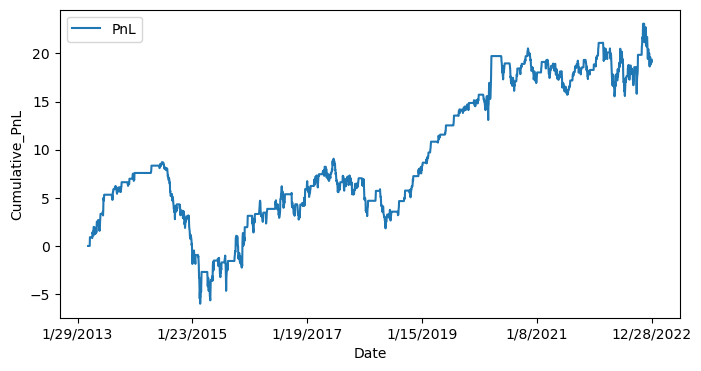

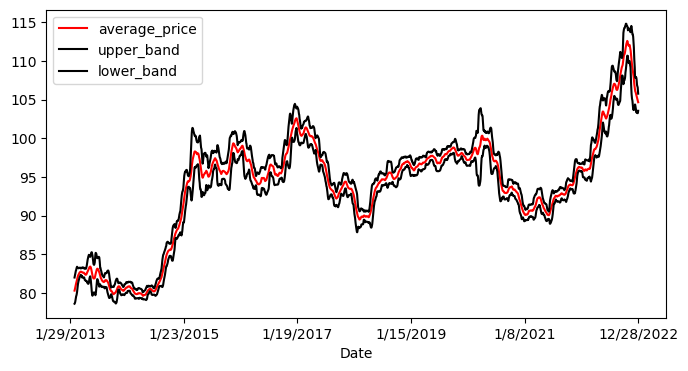

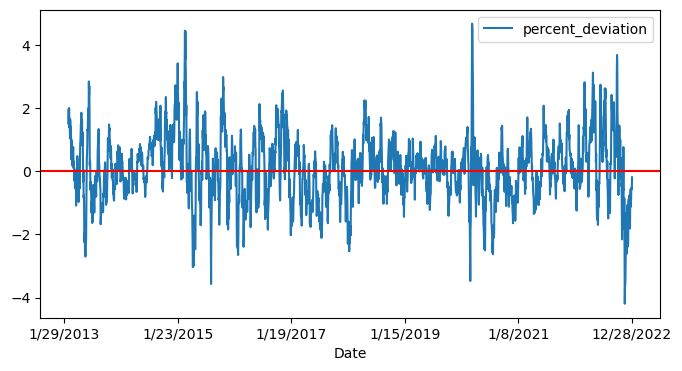

In [3]:
# Plot the returns
df.cumpnl.plot(label='PnL', figsize=(8,4))
plt.xlabel('Date')
plt.ylabel('Cumulative_PnL')
plt.legend()
plt.show()

# Plot the bollinger bands
df.rolling_mean.plot(label='average_price', color='red', figsize=(8,4))
df.upper_band.plot(label='upper_band', color='black', figsize=(8,4))
df.lower_band.plot(label='lower_band', color='black', figsize=(8,4))
plt.legend()
plt.show()

# Plot the deviation
df['percent_deviation'] = ((df.price - df.rolling_mean)/df.rolling_mean)*100
df.percent_deviation.plot(figsize=(8,4))
plt.axhline(y=0, color='red')
plt.legend()
plt.show()